In [275]:
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import normalize
import torch
import torch.nn as nn

from sklearn import metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import pandas as pd
import random
import os
import numpy as np

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
seed_everything(42) # Seed 고정

In [100]:
def lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(14): # ignore 'ID'
        rmse = metrics.mean_squared_error(gt[:,idx], preds[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(gt[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:15])
    return score, all_nrmse

In [5]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [307]:
epochs = 500
lr = 2e-4
bs = 2048

In [6]:
df = pd.read_csv('./train.csv')

train_df, valid_df = train_test_split(df, train_size=0.8)
len(df), len(train_df), len(valid_df)

(39607, 31685, 7922)

In [7]:
train_x = train_df.filter(regex='X') # Input : X Featrue
train_y = train_df.filter(regex='Y') # Output : Y Feature

valid_x = valid_df.filter(regex='X') # Input : X Featrue
valid_y = valid_df.filter(regex='Y') # Output : Y Feature

test_x = pd.read_csv('./test.csv').drop(columns=['ID'])

In [298]:
class CustomDataset(Dataset):
    def __init__(self, x, y=None, norm=False):
        self.x = torch.Tensor(x.values)
        if norm:
            self.x = normalize(self.x, p=2.0)
        
        self.test = True if y is None else False
        if not self.test:
            self.y = torch.Tensor(y.values)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        if self.test:
            return self.x[idx]
        return self.x[idx], self.y[idx]

In [299]:
train_ds = CustomDataset(train_x, train_y, True)
valid_ds = CustomDataset(valid_x, valid_y, True)
test_ds = CustomDataset(test_x)

In [300]:
next(iter(train_ds))

(tensor([ 5.5820e-03,  8.1755e-03,  5.2359e-03,  7.9128e-05,  8.1621e-03,
          5.6105e-03,  2.3390e-03,  7.5496e-03,  1.2519e-02,  0.0000e+00,
          0.0000e+00,  3.4579e-04,  1.5034e-05,  1.0595e-03,  1.0587e-03,
          1.0698e-03,  1.0738e-03,  1.0659e-03,  2.5242e-04,  2.4925e-04,
          2.4372e-04,  2.5400e-04,  7.9128e-05,  1.6775e-04,  1.6617e-04,
          1.6696e-04,  1.6696e-04,  1.6854e-04,  1.7329e-04,  1.0999e-04,
          1.2740e-04,  1.0920e-04,  1.2898e-04,  1.0247e-03,  1.0271e-03,
          1.0247e-03,  1.0208e-03, -1.2676e-03, -1.2668e-03, -1.3238e-03,
          1.6759e-03,  1.6688e-03,  1.6807e-03,  1.6783e-03,  1.1869e-05,
          1.1624e-01,  7.9128e-05,  7.9128e-05,  9.9260e-01,  1.0657e-02,
          1.0283e-02,  1.1036e-02,  1.0469e-02,  9.8722e-03,  1.0578e-02,
          1.0647e-02]),
 tensor([  1.0890,   0.9130,   0.6320,  14.8410,  32.7910,  16.2980,   2.6420,
         -26.7950, -26.8260, -22.6480,  24.0060, -26.7690, -26.8230, -26.6860]))

In [301]:
train_dl = DataLoader(
    dataset=train_ds,
    batch_size=bs,
    shuffle=True,
    drop_last=True
)
valid_dl = DataLoader(
    dataset=valid_ds,
    batch_size=bs
)
test_dl = DataLoader(
    dataset=test_ds,
    batch_size=bs
)

In [302]:
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(56, 128),
            nn.ReLU(),
            # nn.Dropout(0.2),
            
            nn.Linear(128, 256),
            nn.ReLU(),
            # nn.Dropout(0.2),
            
            nn.Linear(256, 512),
            nn.ReLU(),
            # nn.Dropout(0.2),
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            # nn.Dropout(0.2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 14)
        )
    
    def forward(self, x):
        out = self.layer1(x)
        for _ in range(30):
            out = self.layer2(out)
        out = self.layer3(out)
        return out

In [303]:
class CustomModel2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(56, 49),
            nn.ReLU(),
  
            nn.Linear(49, 42),
            nn.ReLU(),
            # nn.Dropout(0.2),
            
            nn.Linear(42, 35),
            nn.ReLU(),
            
            nn.Linear(35, 28),
            nn.ReLU(),
            
            nn.Linear(28, 21),
            nn.ReLU(),
            
            nn.Linear(21, 14),
            nn.ReLU(),
            # nn.Dropout(0.2),
        )
        
        self.layer2 = nn.Sequential(
            nn.Linear(14, 14),
            nn.ReLU(),
            # nn.Dropout(0.2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(14, 14)
        )
    
    def forward(self, x):
        out = self.layer1(x)
        # for _ in range(10):
        #     out = self.layer2(out)
        out = self.layer3(out)
        return out

In [308]:
model = CustomModel2().to(device)
model

CustomModel2(
  (layer1): Sequential(
    (0): Linear(in_features=56, out_features=49, bias=True)
    (1): ReLU()
    (2): Linear(in_features=49, out_features=42, bias=True)
    (3): ReLU()
    (4): Linear(in_features=42, out_features=35, bias=True)
    (5): ReLU()
    (6): Linear(in_features=35, out_features=28, bias=True)
    (7): ReLU()
    (8): Linear(in_features=28, out_features=21, bias=True)
    (9): ReLU()
    (10): Linear(in_features=21, out_features=14, bias=True)
    (11): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=14, out_features=14, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=14, out_features=14, bias=True)
  )
)

In [309]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [310]:
train_losses = np.zeros(epochs)
valid_losses = np.zeros(epochs)

for epoch in range(epochs):
    model.train()
    train_pbar = tqdm(train_dl)
    for idx, (inputs, labels) in enumerate(train_pbar, 1):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outs = model(inputs)
        loss = criterion(outs, labels)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_losses[epoch] += loss.item()
        train_pbar.set_description(f'TRAIN | epoch : {epoch} | loss : {train_losses[epoch] / (bs * idx)}')

    with torch.no_grad():
        model.eval()
        valid_pbar = tqdm(valid_dl)
        for idx, (inputs, labels) in enumerate(valid_pbar, 1):
            inputs = inputs.to(device)
            labels = labels.to(device)
        
            outs = model(inputs)
            loss = criterion(outs, labels)

            valid_losses[epoch] += loss.item()
            valid_pbar.set_description(f'VALID | epoch : {epoch} | loss : {valid_losses[epoch] / (bs * idx)}')

TRAIN | epoch : 0 | loss : 0.20992420017719268: 100%|██████████| 15/15 [00:00<00:00, 67.74it/s]
VALID | epoch : 0 | loss : 0.20978416875004768: 100%|██████████| 4/4 [00:00<00:00, 120.92it/s]
TRAIN | epoch : 1 | loss : 0.20976796448230745: 100%|██████████| 15/15 [00:00<00:00, 51.19it/s]
VALID | epoch : 1 | loss : 0.20961162075400352: 100%|██████████| 4/4 [00:00<00:00, 117.77it/s]
TRAIN | epoch : 2 | loss : 0.20959258675575257: 100%|██████████| 15/15 [00:00<00:00, 48.86it/s]
VALID | epoch : 2 | loss : 0.2094322070479393: 100%|██████████| 4/4 [00:00<00:00, 126.34it/s]
TRAIN | epoch : 3 | loss : 0.20939170718193054: 100%|██████████| 15/15 [00:00<00:00, 72.61it/s]
VALID | epoch : 3 | loss : 0.20924513041973114: 100%|██████████| 4/4 [00:00<00:00, 117.52it/s]
TRAIN | epoch : 4 | loss : 0.2092045396566391: 100%|██████████| 15/15 [00:00<00:00, 48.81it/s] 
VALID | epoch : 4 | loss : 0.20904447510838509: 100%|██████████| 4/4 [00:00<00:00, 114.66it/s]
TRAIN | epoch : 5 | loss : 0.20900161961714428

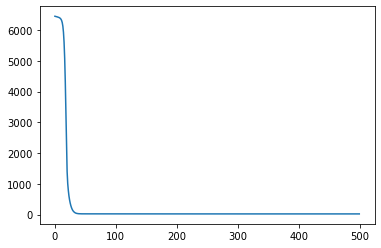

In [311]:
plt.plot(train_losses)

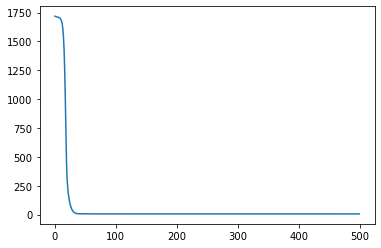

In [312]:
plt.plot(valid_losses)

In [313]:
out = model(normalize(torch.Tensor(valid_x.values).to(device))
out

tensor([[  1.3444,   1.0439,   1.0023,  ..., -26.2605, -26.2414, -26.2333],
        [  1.3413,   1.0485,   1.0042,  ..., -26.2569, -26.2339, -26.2237],
        [  1.3444,   1.0439,   1.0023,  ..., -26.2605, -26.2414, -26.2333],
        ...,
        [  1.3453,   1.0522,   1.0008,  ..., -26.2556, -26.2380, -26.2267],
        [  1.3444,   1.0439,   1.0023,  ..., -26.2605, -26.2414, -26.2333],
        [  1.3444,   1.0439,   1.0023,  ..., -26.2605, -26.2414, -26.2333]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [269]:
out.size()

torch.Size([7922, 14])

In [270]:
pred = out.cpu().detach().numpy()
pred

array([[  1.3444012,   1.0438867,   1.0023144, ..., -26.260517 ,
        -26.241411 , -26.233274 ],
       [  1.3413085,   1.0484796,   1.0042475, ..., -26.256943 ,
        -26.23387  , -26.223717 ],
       [  1.3444012,   1.0438867,   1.0023144, ..., -26.260517 ,
        -26.241411 , -26.233274 ],
       ...,
       [  1.3452948,   1.052218 ,   1.000822 , ..., -26.25555  ,
        -26.238031 , -26.226667 ],
       [  1.3444012,   1.0438867,   1.0023144, ..., -26.260517 ,
        -26.241411 , -26.233274 ],
       [  1.3444012,   1.0438867,   1.0023144, ..., -26.260517 ,
        -26.241411 , -26.233274 ]], dtype=float32)

In [272]:
lg_nrmse(valid_y.values, pred)

(2.00291191682108,
 [0.26355234971865826,
  0.36446535881286624,
  0.35604204462999006,
  0.19567507312578394,
  0.08086759507406788,
  0.10564754890510297,
  0.1316694852240095,
  0.025293822296682738,
  0.025081316662668437,
  0.04038644630150636,
  0.03405252282867054,
  0.025238971143447,
  0.02513969098073948,
  0.025157035559454637])